In [208]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random as rd
import copy

Here you can fix config:

In [209]:
class cfg():
    # Hyper params
    num_epochs = 100
    batch_size = 128
    # Adam optimizer parameters
    lrc = 0.002
    lrg = 0.0002
    beta1 = 0.9

    # Root directory for dataset if you have a personnal dataset
    dataroot = "../data/your_dataset",

    # Image characteristics
    image_size = 28
    nc = 1          # Number of channels 
    nl = 100        # Size of latent vector 

MNIST Dataset (I used LWF for my experiences, don't forget to change nc if you are using another database)**bold text**

### The DATA

In [210]:
'''
dataset = torchvision.datasets.FashionMNIST(root = './FashionMNIST/', download = True,
                                            transform = transforms.Compose([
                                                                            transforms.ToTensor(),
                                                                            transforms.Resize(cfg.image_size)]))
'''
dataset = torchvision.datasets.MNIST(root = './MNIST/', download = True,
                                            transform = transforms.Compose([
                                                                            transforms.ToTensor(),
                                                                            transforms.Resize(cfg.image_size)]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True)

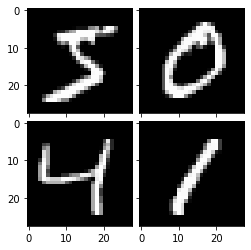

In [211]:
%matplotlib inline

ims = [dataset[i][0].squeeze() for i in range(4)]
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, ims):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')

plt.show()

### Pre-processing

In [212]:
# Custom weights initialization from pytorch DCGAN tutorial
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## **Generator**

In [213]:
class Generator(nn.Module):
    def __init__(self, nc, nl):
      super(Generator, self).__init__()
      self.convs = nn.Sequential(
          nn.ConvTranspose2d(nl, 128, 4, 1, 0, bias=False),
          nn.BatchNorm2d(128),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(128, 64, 3, 2, 1, bias=False),
          nn.BatchNorm2d(64),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
          nn.BatchNorm2d(32),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(32, nc, 4, 2, 1, bias=False),
      )
      self.act = nn.Tanh()
  
    def forward(self, x):
      x = self.convs(x)
      x = self.act(x)
      return x

## **Critic**

In [214]:
class Discriminator(nn.Module):
    def __init__(self, nc):
        super(Discriminator, self).__init__()
        self.convs = nn.Sequential(
                
            nn.Conv2d(nc, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
          )
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.convs(x)
        x = self.sig(x)
        return x.view(-1, 1).squeeze(1)

## **Training**

In [215]:
# Define models
gene = Generator(cfg.nc, cfg.nl).cuda()
crit = Discriminator(cfg.nc).cuda()

# Init weights
gene.apply(weights_init)
crit.apply(weights_init)

Discriminator(
  (convs): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (sig): Sigmoid()
)

In [216]:
# BCELoss function
criterion = nn.BCELoss()

# Create noisy input
fixed_noise = torch.randn(64, cfg.nl, 1, 1).cuda()

# Defining labels
real_label = 1.
fake_label = 0.

# Optimizers
optimizerG = torch.optim.Adam(
    gene.parameters(), lr=cfg.lrg, betas=(cfg.beta1, 0.999))
optimizerD = torch.optim.SGD(crit.parameters(), lr=cfg.lrc)

In [217]:
# Training Loop from DCGAN Pytorch tutorial
# Training Loop
crits = []
gens = []
print("Starting Training Loop...")
for epoch in range(cfg.num_epochs):
    # Save model at mid train
    if epoch > 0:
        crit_tp = copy.deepcopy(crit)
        gene_tp = copy.deepcopy(gene)
        crits.append(crit_tp)
        gens.append(gene_tp)

    for i, data in enumerate(dataloader, 0):
        # Critic
        crit.zero_grad()
        real_cpu = data[0].cuda()
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float).cuda()
        output = crit(real_cpu).squeeze()
        errD_real = criterion(output, label)
        errD_real.backward()
        
        D_x = output.mean().item()
        noise = torch.randn(b_size, cfg.nl, 1, 1).cuda()
        fake = gene(noise)
        label.fill_(fake_label)
        output = crit(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Generator
        gene.zero_grad()
        label.fill_(real_label)
        output = crit(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_C: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, cfg.num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Starting Training Loop...
[1/100][0/469]	Loss_C: 1.5415	Loss_G: 0.9561	D(x): 0.4856	D(G(z)): 0.5264 / 0.4044
[1/100][50/469]	Loss_C: 0.1937	Loss_G: 2.9815	D(x): 0.9158	D(G(z)): 0.0934 / 0.0587
[1/100][100/469]	Loss_C: 0.1817	Loss_G: 3.2147	D(x): 0.9101	D(G(z)): 0.0779 / 0.0461
[1/100][150/469]	Loss_C: 0.1256	Loss_G: 3.3097	D(x): 0.9465	D(G(z)): 0.0660 / 0.0414
[1/100][200/469]	Loss_C: 0.1643	Loss_G: 3.6951	D(x): 0.9312	D(G(z)): 0.0730 / 0.0295
[1/100][250/469]	Loss_C: 0.0750	Loss_G: 3.9141	D(x): 0.9653	D(G(z)): 0.0365 / 0.0233
[1/100][300/469]	Loss_C: 0.0770	Loss_G: 3.8375	D(x): 0.9619	D(G(z)): 0.0352 / 0.0270
[1/100][350/469]	Loss_C: 0.0686	Loss_G: 3.9484	D(x): 0.9677	D(G(z)): 0.0338 / 0.0235
[1/100][400/469]	Loss_C: 0.0700	Loss_G: 3.9070	D(x): 0.9681	D(G(z)): 0.0354 / 0.0222
[1/100][450/469]	Loss_C: 0.0730	Loss_G: 3.8277	D(x): 0.9629	D(G(z)): 0.0325 / 0.0264
[2/100][0/469]	Loss_C: 0.0413	Loss_G: 4.6295	D(x): 0.9839	D(G(z)): 0.0236 / 0.0215
[2/100][50/469]	Loss_C: 0.0846	Loss_G: 3.993

In [242]:
model = gens[98]
imgs = []
for i in range(4):
  noise = torch.randn(1, cfg.nl, 1, 1).cuda()
  gen_img = model(noise)
  imgs.append(gen_img)

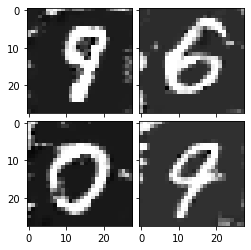

In [243]:
%matplotlib inline

ims = rd.sample([imgs[i].detach().cpu().squeeze() for i in range(4)], 4)
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, ims):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')

plt.show()